### Log Anomaly Detection

This notebook will cover:
* Log Preprocessing
* Text Encoding
* Model Training
* Generating Anomaly Scores
* Model Inference /Prediction

In [ ]:
!pip install git+https://github.com/sevamoo/SOMPY.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/sevamoo/SOMPY.git to /tmp/pip-req-build-j3cvqncq
  Running command git clone -q https://github.com/sevamoo/SOMPY.git /tmp/pip-req-build-j3cvqncq
  Created wheel for SOMPY: filename=SOMPY-1.1.1-py3-none-any.whl size=29207 sha256=45afcf5451e02af099874d6ecb52fca4840c2f0e816205c0ff41ce5079fbf1e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-wvyt949m/wheels/8b/81/b8/f2f0b9e71a0be3b20bce8b0198151e55102565195482fb882c
Successfully built SOMPY


### Import our packages

In [ ]:
import os
import time
import numpy as np
import logging
import sompy



from multiprocessing import Pool
from itertools import product
import pandas as pd
import re
import gensim as gs
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
%matplotlib inline

NumExpr defaulting to 2 threads.
'pattern' package not found; tag filters are not available for English
Loaded backend module://ipykernel.pylab.backend_inline version unknown.


### Define our Functions

#### 1. Log Preprocesing

One assumption that all these functions use is that we instantly convert our data into a pandas dataframe that has a "message" column containing the relevent information for us. 

We then treat each individual log line as a "word", cleaning it by removing all non-alphabet charcters including white spaces. 

In [ ]:
def _preprocess(data):
    for col in data.columns:
        if col == "message":
            data[col] = data[col].apply(_clean_message)
        else:
            data[col] = data[col].apply(to_str)

    data = data.fillna("EMPTY")
    
def _clean_message(line):
    """Remove all none alphabetical characters from message strings."""
    return "".join(
        re.findall("[a-zA-Z]+", line)
    )  # Leaving only a-z in there as numbers add to anomalousness quite a bit

def to_str(x):
    """Convert all non-str lists to string lists for Word2Vec."""
    ret = " ".join([str(y) for y in x]) if isinstance(x, list) else str(x)
    return ret

#### 2. Text Encoding  

Here we employ the gensim implementation of Word2Vec to encode our logs as fixed length numerical vectors. Logs are noteably not the natural usecase for word2vec, but this appraoch attemps to leverage the fact that logs lines themselves, like words, have a context, so encoding a log based on its co-occurence with other logs does make some intuitive sense.

In [ ]:
def create(words, vector_length, window_size):
    """Create new word2vec model."""
    w2vmodel = {}
    for col in words.columns:
        if col in words:
            w2vmodel[col] = gs.models.Word2Vec([list(words[col])], min_count=1, size=vector_length, 
                                     window=window_size, seed=42, workers=1, iter=550,sg=0)
            # (gs) : This package contains interfaces and functionality to compute pair-wise document similarities within a corpus of documents.
            # (models) : This package contains algorithms for extracting document representations from their raw bag-of-word counts.
        else:
            pass
        
    return w2vmodel

def one_vector(new_D, w2vmodel):
    """Create a single vector from model."""
    transforms = {}
    for col in w2vmodel.keys():
        if col in new_D:
            transforms[col] = w2vmodel[col].wv[new_D[col]]

    new_data = []

    for i in range(len(transforms["message"])):
        logc = np.array(0)
        for _, c in transforms.items():
            if c.item(i):
                logc = np.append(logc, c[i])
            else:
                logc = np.append(logc, [0, 0, 0, 0, 0])
        new_data.append(logc)

    return np.array(new_data, ndmin=2)


#### 3. Model Training

Here we employ the SOMPY implementation of the Self-Organizing Map to train our model. This function simply makes it a bit easier for the user to interact with the sompy training requirements. This function returns a trained model.

The trained model object also has a method called codebook.matrix() which allows the user access directly to the trained self organizing map itself. If the map successfull converged then it should consist of nodes in our N-dimensional log space that are well ordered and provide an approximation to the topology of the logs in our training set.

During training we also, compute the distances of our training data to the trained map as a baseline to build a threashold.   

In [ ]:
def train(inp, map_size, iterations, parallelism):
    print('training dataset is of size {inp.shape[0]}')
    mapsize = [map_size, map_size]
    np.random.seed(42)
    som = sompy.SOMFactory.build(inp, mapsize , initialization='random')
    som.train(n_job=parallelism, train_rough_len=100,train_finetune_len=5)
    model = som.codebook.matrix.reshape([map_size, map_size, inp.shape[1]])
    
    #distances = get_anomaly_score(inp, 8, model)
    #threshold = 3*np.std(distances) + np.mean(distances)
    
    return som #,threshold

#### 4. Generating Anomaly Scores

One of the key elements of this approach is quantifying the distance between our logs and the nodes on our self organizing map. The two functions below, taken together, represent a parrallel implementation for performing this calculaton.  

In [ ]:
def get_anomaly_score(logs, parallelism, model): # for whole dataset 

    parameters = [[x,model] for x in logs]
    pool = Pool(parallelism)
    dist = pool.map(calculate_anomaly_score, parameters) 
    pool.close()
    pool.join()
    #dist = [] 
    #for log in logs:
    #    dist.append(calculate_anomaly_score(log,model))
    
    return dist

def calculate_anomaly_score(parameters): # for a data point 
    log = parameters[0]
    model = parameters[1]
    """Compute a distance of a log entry to elements of SOM."""
    dist_smallest = np.inf
    for x in range(model.shape[0]):
        for y in range(model.shape[1]):
            dist = cosine(model[x][y],log) 
            #dist = np.linalg.norm(model[x][y] - log)
            if dist < dist_smallest:
                dist_smallest = dist
    return dist_smallest


#### 5. Model Inference / Prediction

Here we are making an inference about a new log message. This is done by scoring the incoming log and evaluating whether or not it passess a certain threshold value.  


Ideally our word2vec has been monitoring our application long enough to have seen all the logs. So, if we get a known log we can simply look up its vector representation   

One downside with word2vec is that its quite brittle when it comes to incorporating words that haven't been seen before. In this example, we will retrain the W2Vmodel if our new log has not been seen by the before.  

In [ ]:
def infer(w2v, som, log, data, threshold):
    
    log =  pd.DataFrame({"message":log},index=[1])
    _preprocess(log)
    
    if log.message.iloc[0] in list(w2v['message'].wv.vocab.keys()):
        vector = w2v["message"].wv[log.message.iloc[0]]
    else:
        w2v = gs.models.Word2Vec([[log.message.iloc[0]] + list(data["message"])], 
                                 min_count=1, size=100, window=3, seed=42, workers=1, iter=550, sg=0)
        vector = w2v.wv[log.message.iloc[0]]
    
    score = get_anomaly_score([vector], 1, som)
    
    if score < threshold:
        return 0, score
    else:
        return 1, score


### Implementation

First we read in our test dataset and preprocess it.

In [ ]:
data_path = "/content/Hadoop_2k.json"

In [ ]:
data = pd.read_json(data_path)


In [ ]:
_preprocess(data)
data.head()

,message
0,INFOmainorgapachehadoopmapreducevappMRAppMaste...
1,INFOmainorgapachehadoopmapreducevappMRAppMaste...
2,INFOmainorgapachehadoopmapreducevappMRAppMaste...
3,INFOmainorgapachehadoopmapreducevappMRAppMaste...
4,INFOmainorgapachehadoopmapreducevappMRAppMaste...


In [ ]:
data.tail()

,message
1995,gqlFHdexseojlPOYzndoaYGDlPJlPYIcQcraRapMJnekqA...
1996,WARNLeaseRenewermsrabimsrasaorgapachehadoophdf...
1997,gNlFHpMxohkfnfpalnrAlYkcaPSrPkrgQpaMDcQcaaRoGM...
1998,ERRORRMCommunicatorAllocatororgapachehadoopmap...
1999,gqlFHdexseojlPOYzndoaYGDlPJlPYIcQcraRapMJnekqA...


In [ ]:
x = data.message.value_counts()
for i in x.keys():
    print(i, x[i])

WARNLeaseRenewermsrabimsrasaorgapachehadoophdfsLeaseRenewerFailedtorenewleaseforDFSClientNONMAPREDUCEforsecondsWillretryshortly 326
INFOIPCServerhandleronorgapachehadoopmapredTaskAttemptListenerImplProgressofTaskAttemptattemptmis 289
WARNLeaseRenewermsrabimsrasaorgapachehadoopipcClientAddresschangedetectedOldmsrasaNewmsrasa 212
ERRORRMCommunicatorAllocatororgapachehadoopmapreducevapprmRMContainerAllocatorERRORINCONTACTINGRM 147
INFORMCommunicatorAllocatororgapachehadoopmapreducevapprmRMContainerAllocatorRecalculatingscheduleheadroommemoryvCores 131
INFORMCommunicatorAllocatororgapachehadoopmapreducevapprmRMContainerAllocatorReduceslowstartthresholdnotmetcompletedMapsForReduceSlowstart 130
gqlFHdexseojlPOYzndoaYGDlPJlPYIcQcraRapMJnekqAEfxKiKpdClariPkAFvePZNcvEgtHgeteyKWgOldzoraaWJPxtNNFZgPNxrvGrOcsFeZd 115
WARNRMCommunicatorAllocatororgapachehadoopipcClientAddresschangedetectedOldmsrasaNewmsrasa 89
INFORMCommunicatorAllocatororgapachehadoopipcClientRetryingconnecttoservermsrasaAlreadytr

#### Encode our logs

We then create our w2vmodel based on our preprocessed dataset and replace our log lines with its vectorized representation. 

In [ ]:
w2vmodel = create(data, 100, 3)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 141 word types from a corpus of 2000 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 141 unique words (100% of original 141, drops 0)
effective_min_count=1 leaves 2000 word corpus (100% of original 2000, drops 0)
deleting the raw counts dictionary of 141 items
sample=0.001 downsamples 30 most-common words
downsampling leaves estimated 474 word corpus (23.7% of prior 2000)
estimated required memory for 141 words and 100 dimensions: 183300 bytes
resetting layer weights
training model with 1 workers on 141 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 2000 raw words (455 effective words) took 0.0s, 31493 effective words/s
job loop exiting, total 1 jobs
worker exiting,

In [ ]:
transformed_data = one_vector(data, w2vmodel)
transformed_data = transformed_data[:,1:]

# Implement Local Outlier Factor

Use preprocessed data in local outlier factor model to classify anomaly logs.
Local outlier factor is a density-based method that relies on nearest neighbours search. The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors.

Preselected parameter k is the number of neighbors the LOF calculation is considering. The LOF is a calculation that looks at the neighbors of a certain point to find out its density and compare this to the density of other points. With k defined, the k-distance can be calculated, which is the distance of a point to its kth neighbor.


The k-distance is used to calculate the reachability distance. This distance measure is simply the maximum of the distance of two points and the k-distance of the second point.

$reachability-dist(a,b) = max\{k-distance(b), dist(a,b)\}$


The reach-dist is then used to calculate still another concept — the local reachability density (lrd). To get the lrd for a point a, we will first calculate the reachability distance of a to all its k nearest neighbors and take the average of that number. The lrd is then simply the inverse of that average. 

$lrd(a) = \frac{1}{sum(reach-dist(a,n))/k}$


The lrd of each point will then be compared to the lrd of their k neighbors. More specifically, k ratios of the lrd of each point to its neighboring points will be calculated and averaged. The LOF is basically the average ratio of the lrds of the neighbors of a to the lrd of a. If the ratio is greater than 1, the density of point a is on average smaller than the density of its neighbors and, thus, from point a, we have to travel longer distances to get to the next point or cluster of points than from a’s neighbors to their next neighbors. 

The LOF of a point tells the density of this point compared to the density of its neighbors. If the density of a point is much smaller than the densities of its neighbors (LOF ≫1), the point is far from dense areas and, hence, an outlier.

In [ ]:
type(transformed_data) #numpy.ndarray
#transformed_data.shape #(10000, 100)

numpy.ndarray

# Parameter Selection
For number of neighbours being considered



In [ ]:
from sklearn.neighbors import LocalOutlierFactor
print(__doc__)

X=transformed_data
clf = LocalOutlierFactor(n_neighbors=300, metric='euclidean')
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_


Automatically created module for IPython interactive environment


In [ ]:
X_scores.shape

(2000,)

In [ ]:
#type(y_pred)#numpy.ndarray
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{-1: 241, 1: 1759}

# Dimension Reduction 
Since the dimension of the feature is large, we cannot visualize it. PCA is used to reduce dimension of data.

The number of PCA component is decided by using the ratio of variance explained by each of the selected components.

Same classification result obtained after PCA compared with before PCA. 

In [ ]:
#Use PCA to extract key features and visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 


scaler=preprocessing.StandardScaler().fit(X) 
X_transformed=scaler.transform(X) 

print("shape of train data before pca", X_transformed.shape)


N_components=2
Data_pca=PCA(n_components=N_components).fit(X_transformed)
X_pca=Data_pca.transform(X_transformed)

print("shape of train data after pca", X_pca.shape)

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


shape of train data before pca (2000, 100)
shape of train data after pca (2000, 2)


In [ ]:
unique2, counts2 = np.unique(X_pca, return_counts=True)
dict(zip(unique2, counts2))

{-7.984108427089351: 10,
 -7.729348734613644: 289,
 -7.263369617049926: 12,
 -7.260423750981349: 10,
 -7.172114977447807: 10,
 -6.751490011316509: 12,
 -6.532919026095656: 131,
 -6.457017554997071: 130,
 -6.237185601416102: 10,
 -5.893804199695828: 10,
 -5.890453254209386: 2,
 -5.752328302332756: 289,
 -5.751305209343775: 10,
 -5.605334652879162: 10,
 -4.965499538521058: 10,
 -4.8955080198848595: 10,
 -4.654930277892534: 1,
 -4.481490632413831: 2,
 -4.361681425072224: 1,
 -4.312985570907976: 10,
 -4.122940354463615: 212,
 -3.914130249209675: 89,
 -3.850935482997621: 10,
 -3.643695498068834: 10,
 -3.2979929661372362: 1,
 -3.1585874310480375: 7,
 -3.0679727513929658: 8,
 -2.7484533761025847: 1,
 -2.7282431174831885: 2,
 -2.6032344207928806: 1,
 -2.5429506156220576: 89,
 -2.3320677251234034: 33,
 -2.265492689863913: 1,
 -1.7360873046454106: 1,
 -1.729143132695337: 1,
 -1.7283632100944946: 1,
 -1.5414000901995144: 2,
 -1.22989389135562: 326,
 -0.7350797985816752: 1,
 -0.35140580827063594: 

In [ ]:
print("variance explained", Data_pca.explained_variance_ratio_ )

variance explained [0.28089551 0.18658914]


In [ ]:
y_pred_pca = clf.fit_predict(X_pca)
X_scores_pca = clf.negative_outlier_factor_


unique_pca, counts_pca = np.unique(y_pred_pca, return_counts=True)
dict(zip(unique_pca, counts_pca))

{-1: 228, 1: 1772}

# Visualization

The plot visualize the data after PCA. 
The red circles are where the data points are clustered and have higher density. The larger circle is a cluster having more points, and the small circle is the cluster having lesser points.

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'STIXSizeTwoSym' (STIXS

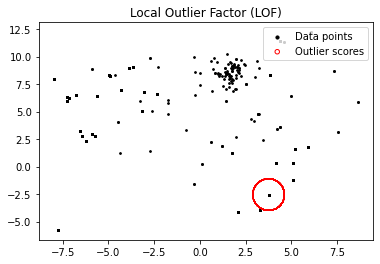

In [ ]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X_pca[:, 0], X_pca[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores_pca.max() - X_scores_pca) / (X_scores_pca.max() - X_scores_pca.min())
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')

legend = plt.legend(loc='upper right')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

#### Now use following 
#### Train SOM

Here we train the Self Organizing Map on our vectorized logs and output a visualizations of the trained model

In [ ]:
map_size = 16
model = train(transformed_data, map_size, 0, 2)

 Training...
 random_initialization took: 0.002000 seconds
 Rough training...
 radius_ini: 6.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.124000, quantization error: 16.714330



training dataset is of size {inp.shape[0]}


 epoch: 2 ---> elapsed time:  0.115000, quantization error: 7.828996

 epoch: 3 ---> elapsed time:  0.112000, quantization error: 6.258585

 epoch: 4 ---> elapsed time:  0.113000, quantization error: 6.085512

 epoch: 5 ---> elapsed time:  0.111000, quantization error: 6.001976

 epoch: 6 ---> elapsed time:  0.113000, quantization error: 5.943400

 epoch: 7 ---> elapsed time:  0.109000, quantization error: 5.870202

 epoch: 8 ---> elapsed time:  0.116000, quantization error: 5.817209

 epoch: 9 ---> elapsed time:  0.120000, quantization error: 5.764530

 epoch: 10 ---> elapsed time:  0.112000, quantization error: 5.734759

 epoch: 11 ---> elapsed time:  0.114000, quantization error: 5.676761

 epoch: 12 ---> elapsed time:  0.114000, quantization error: 5.631711

 epoch: 13 ---> elapsed time:  0.111000, quantization error: 5.594215

 epoch: 14 ---> elapsed time:  0.113000, quantization error: 5.544082

 epoch: 15 ---> elapsed time:  0.114000, quantization error: 5.506834

 epoch: 16 ---

/usr/local/lib/python3.7/dist-packages/sompy/visualization/hitmap.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


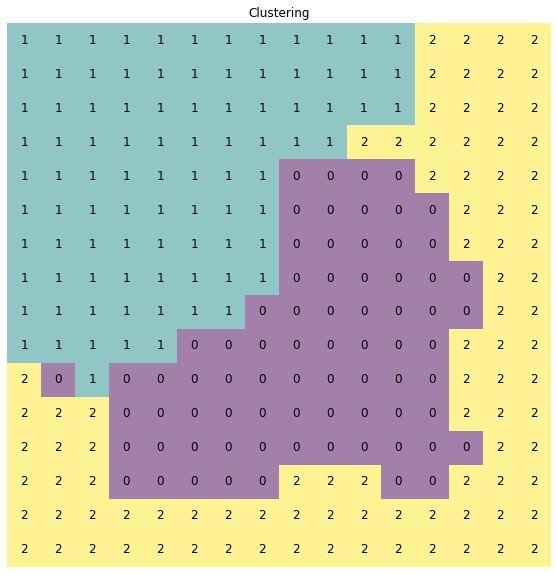

In [ ]:
from sompy.visualization.hitmap import HitMapView
model.cluster(3)
hits  = HitMapView(10,10,"Clustering",text_size=7)
a=hits.show(model, labelsize=12)

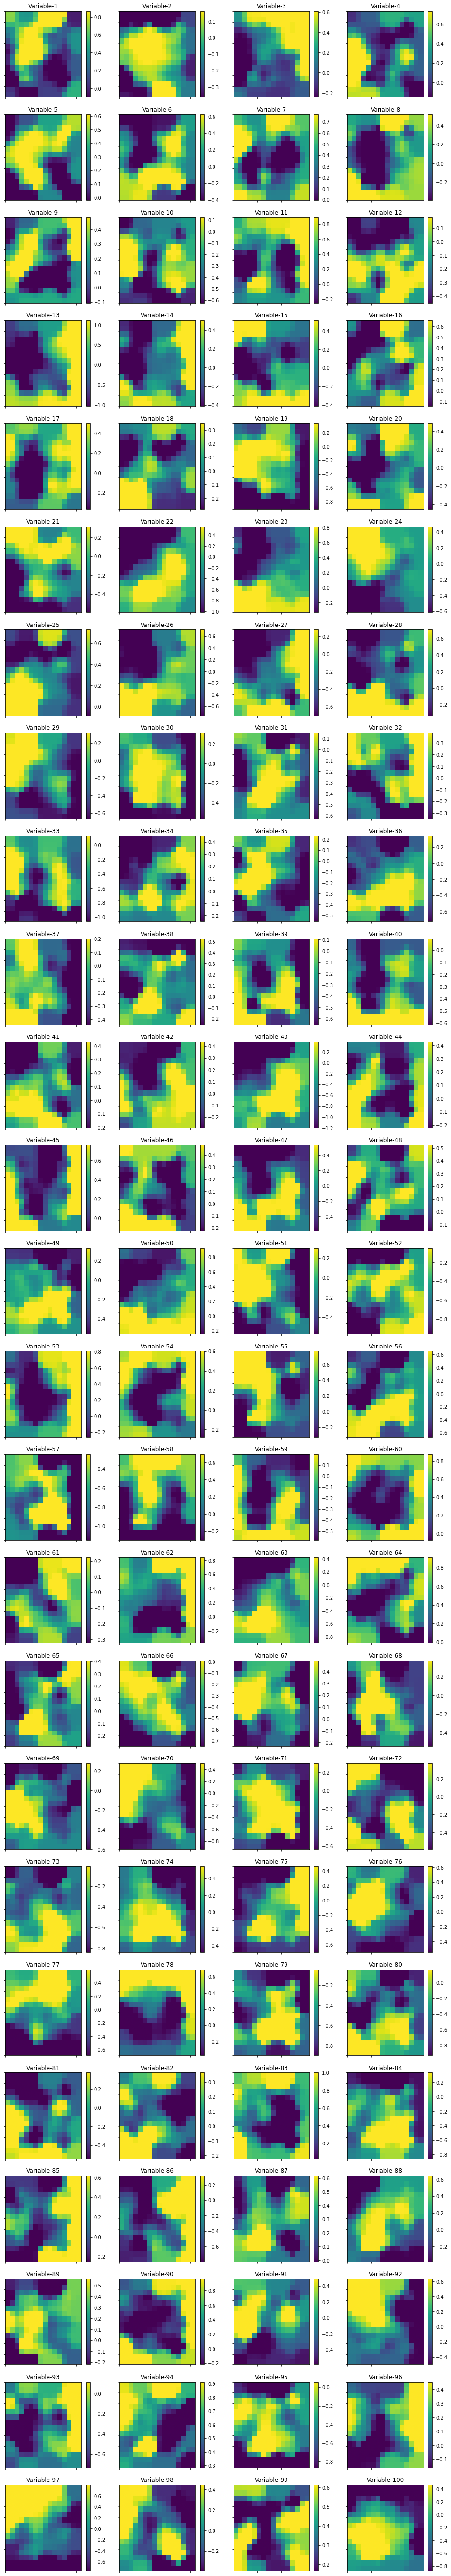

In [ ]:
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=10)
view2D.show(model, col_sz=4, which_dim="all", denormalize=True)

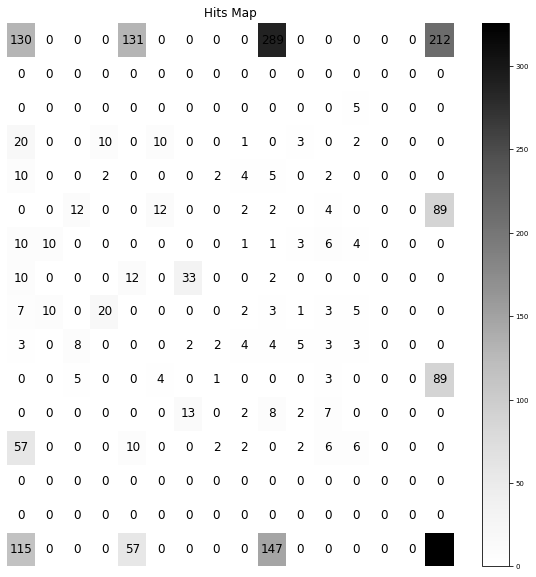

In [ ]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(10,10,"Hits Map",text_size=7)
vhts.show(model, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

In [ ]:
m = model.codebook.matrix.reshape([16, 16, transformed_data.shape[1]])

In [ ]:
import pickle
pickle.dump(m, open('m.pkl', 'wb'))

#### Measure Distances

We want to generate some baseline summary statistics of our model

In [ ]:
#then = time.
distances = get_anomaly_score(transformed_data, 8, m)

print(max(distances))
print(min(distances))
print(np.mean(distances))
print(np.std(distances))

0.4813488968632822
0.06185108685955232
0.22874957075756555
0.06641569249810547


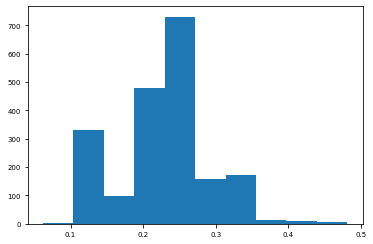

In [ ]:
plt.hist(distances)
plt.show()

In [ ]:
threshold = 3*np.std(distances) + np.mean(distances)
threshold

0.427996648251882

In [ ]:
threshold

0.427996648251882

In [ ]:
count = 0
for i, j in enumerate(distances):
    if j > threshold:
        print(j, data.loc[i])
        count += 1
print(count)

0.46122086797699036 message    INFOAsyncDispatchereventhandlerorgapachehadoop...
Name: 121, dtype: object
0.46943888902738695 message    INFOAsyncDispatchereventhandlerorgapachehadoop...
Name: 122, dtype: object
0.47045041911577457 message    INFOAsyncDispatchereventhandlerorgapachehadoop...
Name: 123, dtype: object
0.46607301244986354 message    INFOAsyncDispatchereventhandlerorgapachehadoop...
Name: 124, dtype: object
0.46166140567862524 message    INFOAsyncDispatchereventhandlerorgapachehadoop...
Name: 798, dtype: object
0.4348088913880884 message    INFODefaultSpeculatorbackgroundprocessingorgap...
Name: 816, dtype: object
0.4813488968632822 message    WARNResponseProcessorforblockBPblkorgapachehad...
Name: 908, dtype: object
0.4637961545524195 message    WARNDataStreamerforfiletmphadoopyarnstagingmsr...
Name: 909, dtype: object
0.46000068179418774 message    WARNDataStreamerforfiletmphadoopyarnstagingmsr...
Name: 910, dtype: object
0.43131664812760495 message    WARNDataStreamerfo

In [ ]:
data.message.value_counts()

WARNLeaseRenewermsrabimsrasaorgapachehadoophdfsLeaseRenewerFailedtorenewleaseforDFSClientNONMAPREDUCEforsecondsWillretryshortly                                       326
INFOIPCServerhandleronorgapachehadoopmapredTaskAttemptListenerImplProgressofTaskAttemptattemptmis                                                                     289
WARNLeaseRenewermsrabimsrasaorgapachehadoopipcClientAddresschangedetectedOldmsrasaNewmsrasa                                                                           212
ERRORRMCommunicatorAllocatororgapachehadoopmapreducevapprmRMContainerAllocatorERRORINCONTACTINGRM                                                                     147
INFORMCommunicatorAllocatororgapachehadoopmapreducevapprmRMContainerAllocatorRecalculatingscheduleheadroommemoryvCores                                                131
                                                                                                                                                      

#### Test 

In [ ]:
infer(w2vmodel,m,'WARNLeaseRenewermsrabimsrasaorgapachehadoophdfsLeaseRenewerFailedtorenewleaseforDFSClientNONMAPREDUCEforsecondsWillretryshortly', data,threshold) #low

(0, [0.2651017008409149])

In [ ]:
infer(w2vmodel,m,'WARNLeaseRenewermsrabimsrasaorgapachehadoopipcClientAddresschangedetectedOldmsrasaNewmsrasa', data,threshold) #highest

(0, [0.23408275565511472])

In [ ]:
infer(w2vmodel,m,'INFOmainorgmortbaylogStartedHttpServerSelectChannelConnectorWithSafeStartup', data,threshold)

(0, [0.3339997736104169])

In [ ]:
infer(w2vmodel,m,'INFORMCommunicatorAllocatororgapachehadoopyarnutilRackResolverResolvedDNIQfareastcorpmicrosoftcomtodefaultrack', data,threshold) #med

(0, [0.1733092982035067])

In [ ]:
infer(w2vmodel,m,'WARNDataStreamerforfiletmphadoopyarnstagingmsrabistagingjobjobjhistblockBPblkorgapachehadoophdfsDFSClientDataStreamerException',data,threshold)

(1, [0.4313166685025609])

In [ ]:
x = infer(w2vmodel,m,'WARNDataStreamerforfiletmphadoopyarnstagingmsrabistagingjobjobjhistblockBPblkorgapachehadoophdfsDFSClientDataStreamerException',data,threshold).count(1)
if x == 1:
  print("Anomaly detected")
else:
  print("No anomaly found")

Anomaly detected


In [ ]:
infer(w2vmodel,m,'message',data,threshold)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 142 word types from a corpus of 2001 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 142 unique words (100% of original 142, drops 0)
effective_min_count=1 leaves 2001 word corpus (100% of original 2001, drops 0)
deleting the raw counts dictionary of 142 items
sample=0.001 downsamples 30 most-common words
downsampling leaves estimated 475 word corpus (23.8% of prior 2001)
estimated required memory for 142 words and 100 dimensions: 184600 bytes
resetting layer weights
training model with 1 workers on 142 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 2001 raw words (448 effective words) took 0.0s, 87524 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 2 : training on 2001 raw words (494 effectiv

(0, [0.3622318121061051])

In [ ]:
a = len(data.message.value_counts().index)
for i in range(0, a):
  print(data.message.value_counts().index[i]," : ",infer(w2vmodel,m,data.message.value_counts().index[i],data,threshold))

WARNLeaseRenewermsrabimsrasaorgapachehadoophdfsLeaseRenewerFailedtorenewleaseforDFSClientNONMAPREDUCEforsecondsWillretryshortly  :  (0, [0.2651017008409149])
INFOIPCServerhandleronorgapachehadoopmapredTaskAttemptListenerImplProgressofTaskAttemptattemptmis  :  (0, [0.11807617892231004])
WARNLeaseRenewermsrabimsrasaorgapachehadoopipcClientAddresschangedetectedOldmsrasaNewmsrasa  :  (0, [0.23408275565511472])
ERRORRMCommunicatorAllocatororgapachehadoopmapreducevapprmRMContainerAllocatorERRORINCONTACTINGRM  :  (0, [0.34002513018199754])
INFORMCommunicatorAllocatororgapachehadoopmapreducevapprmRMContainerAllocatorRecalculatingscheduleheadroommemoryvCores  :  (0, [0.21109696199080064])
INFORMCommunicatorAllocatororgapachehadoopmapreducevapprmRMContainerAllocatorReduceslowstartthresholdnotmetcompletedMapsForReduceSlowstart  :  (0, [0.2643089134438871])
gqlFHdexseojlPOYzndoaYGDlPJlPYIcQcraRapMJnekqAEfxKiKpdClariPkAFvePZNcvEgtHgeteyKWgOldzoraaWJPxtNNFZgPNxrvGrOcsFeZd  :  (0, [0.1989961014138097

In [ ]:
a = len(data.message.value_counts().index)
x = y = 0
countx = county = 0
for i in range(0, a):
  x = infer(w2vmodel,m,data.message.value_counts().index[i],data,threshold).count(1)
  if x == 0:
    countx = countx + 1
  else:
    county = county + 1

print("Not anomalies: ", countx)
print("Number of anomalies: ", county)

Not anomalies:  131
Number of anomalies:  10
